# Faster and more accurate calculation of the optical forces in the geometrical optics regime using deep learning - A tutorial

This tutorial will guide you through the process of calculating optical forces using neural networks. We will start calculating the forces acting on a sphere with 3DoF and we will expand the calculation up to 9DoF. We will also exemplify how you can use these calculations to numerically simulate the dynamics of a sphere or to calculate the dependence of the stiffness of a trap with the aspect ratio of the ellipsoid.

Finally we will show how you can train your own NN.

Tutorial prepared by David Bronte Ciriza - brontecir@gmail.com

First we import the libraries that we will need for the optical force calculations and we define the variables for the plots.

In [4]:
import numpy as np
import math
import tensorflow as tf

import random
import matplotlib.pyplot as plt
import os

from mpl_toolkits.axes_grid1 import make_axes_locatable


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

VERYSMALL_SIZE=20
SMALL_SIZE = 30
MEDIUM_SIZE = 25
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes\n",
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title\n",
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels\n",
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels\n",
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels\n",
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize\n",
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure titl\n",

We check that we are using the GPU (not neccesary)

In [7]:
tf.test.gpu_device_name()

''

### Sphere: 3 degrees of freedom

We start with the case of the sphere, a problem with 3 inputs ($x,y,z$) and 3 outputs ($F_x,F_y,F_z$)

We load our NN. There are 3 NNs available trained with data generated with different numbers of rays (100, 400 and 1600).

In [10]:
Path=os.getcwd()
Path

'C:\\Users\\Usuario\\Desktop\\Tutorial'

In [11]:
model10_sphere = tf.keras.models.load_model(Path+'\\NN_100RaysSphere')

We can check the archtecture of the NN that has been loaded:

In [12]:
model10_sphere.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_84 (Dense)             (None, 16)                64        
_________________________________________________________________
dense_85 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_86 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_87 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_88 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_89 (Dense)             (None, 3)                 51        
Total params: 1,203
Trainable params: 1,203
Non-trainable params: 0
___________________________________________________

We generate a 2D array where with the input data, we choose as input data the x-axis. The units are in $\rm \mu m$.

In [13]:
X_axis=np.zeros([101,3])
X_axis[:,0]=np.linspace(-4,4,101)


Now we can use the NN to predict what is the value of the force at those given points. The NN provides a 2D array with the force in $\rm fN$. With these NN the forces can be computed for this particular set of parameters considered (see the attached scheme for extra information):

<ol>
  <p>Power $P=5 \rm mW$.</p>
  <p>Refractive index of medium $n_m=1.33$.</p>
  <p>Refractive index of the particle $n_r=1.5$.</p>
  <p>Radius of the particle $R_p=1 \rm \mu m$.</p>
  <p>Focal length $f=0.1 \rm mm$.</p>
  <p>Numerical aperture $NA=1.3$.</p>
  <p>Beam waist $\omega_0=0.1\rm mm$.</p>
    
</ol>

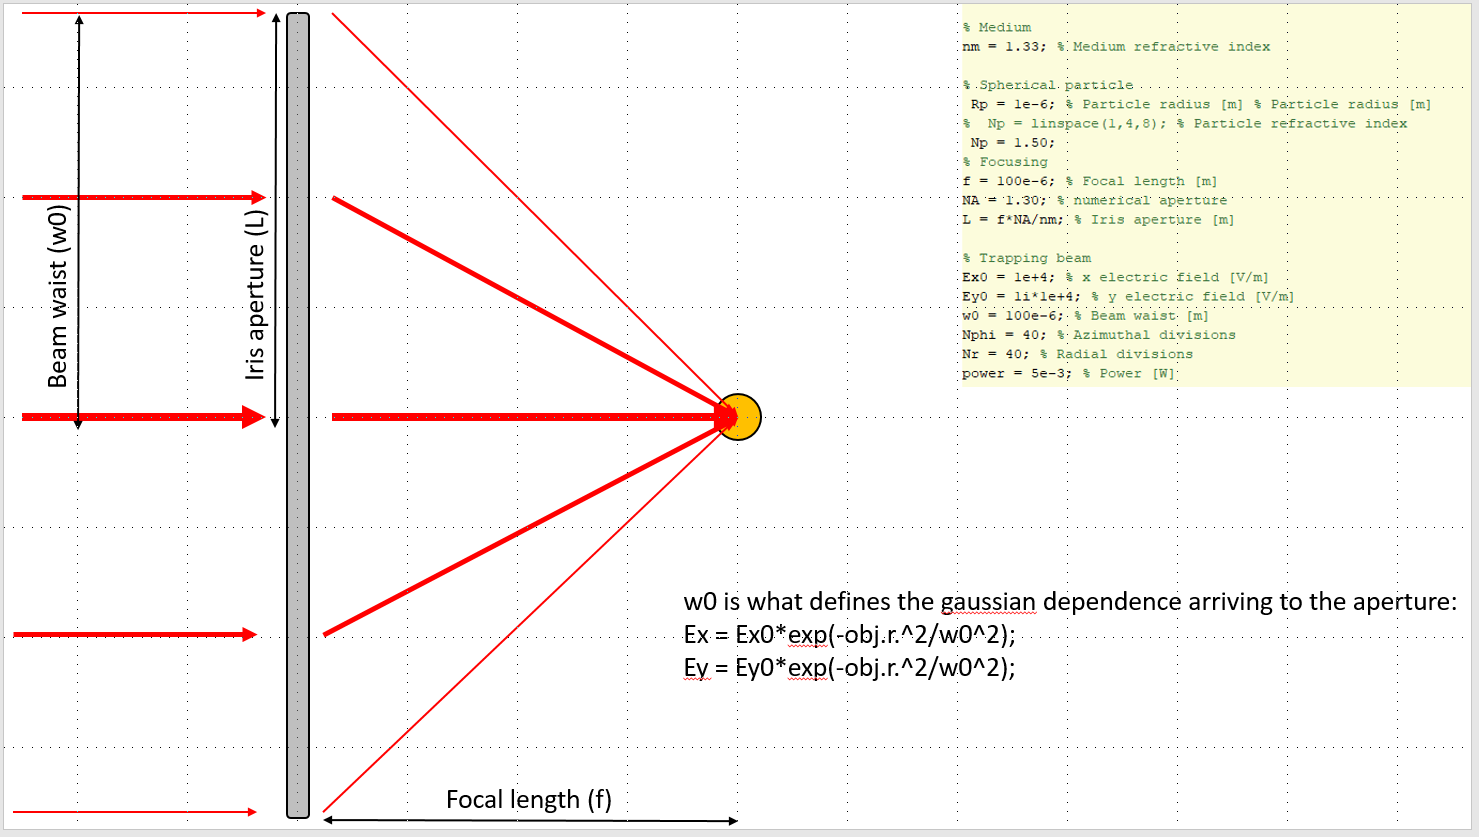

The values of $f$ and $w_0$ determine the profile of the beam that reaches the particle 

In [14]:
Forces_X_axis=model10_sphere.predict(X_axis)

And we can easily plot the results:

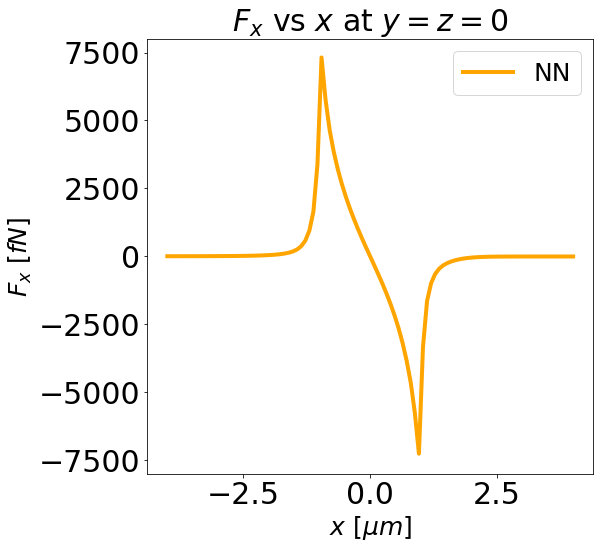

In [15]:
plt.plot(X_axis[:,0],Forces_X_axis[:,0],c='orange',linewidth=4)
plt.legend(['NN'])

plt.title('$F_x$ vs $x$ at $y=z=0$')
plt.xlabel('$x$ $[\mu m]$')
plt.ylabel('$F_x$ $[fN]$')

plt.ylim([-8000,8000])

plt.gcf().set_size_inches(8, 8)

If we just want to compute the force at one particular time we do (for example at position $x=-0.5\rm \mu m, y=z=0$):

In [30]:
Point=[-0.5,0,0]

In [31]:
Forces_Point=model10_sphere.predict([Point])

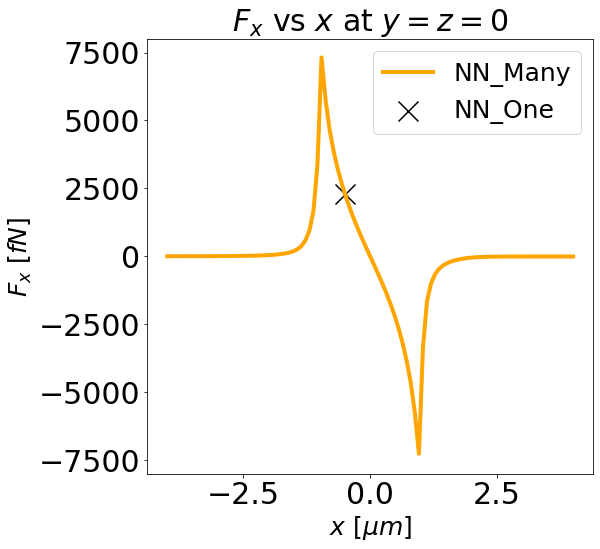

In [33]:

plt.plot(X_axis[:,0],Forces_X_axis[:,0],c='orange',linewidth=4)
plt.scatter(Point[0],Forces_Point[0][0],c='k',s=400, marker='x')

plt.legend(['NN_Many','NN_One'])

plt.title('$F_x$ vs $x$ at $y=z=0$')
plt.xlabel('$x$ $[\mu m]$')
plt.ylabel('$F_x$ $[fN]$')

plt.ylim([-8000,8000])

plt.gcf().set_size_inches(8, 8)

Finally, let's try to simulate the motion of a particle in an optical tweezers. We will use the Langevin equations for the dynamics. The optical force is calculated with the NN.

We define the experimental parameters:

In [34]:
PowerAfterTheObjective=0.001 # [W]
CorrectionForThePower=PowerAfterTheObjective/0.005

kB=1.3806E-23       # [(kg·m^2)/(K·s^2)]
T = 273+20          # [K]
Radius = 1.03E-6    # [m]
#Check viscosity value
Viscosity = 0.00002414*10**(247.8/(-140+T))  # [Pa·s]
Gamma = 6*math.pi*Viscosity*Radius

D=kB*T/Gamma

We define the variables where we will store the trajectories:

In [35]:
N=5000 #numero di punti nel tempo
Experiments=1 #numero di esperimenti simulati

delta_t=0.001

x_trapped=np.zeros([Experiments,N])
y_trapped=np.zeros([Experiments,N])
z_trapped=np.zeros([Experiments,N])

We simulate the trajectories. The code is not optimized for computational speed but for clarity. The first loop goes over the number of trajectories we are computing, the second loop goes over the total number of time steps. We need to calculate the forces with the proper units (both in the input and the output), and once we have done this we can include the optical contribution in the dynamics.

In [36]:
for exp in range (0,Experiments):
    for t in range (1,N):
        PointPrev=[x_trapped[exp,t-1]*1e6,y_trapped[exp,t-1]*1e6,z_trapped[exp,t-1]*1e6]
        ForcesNN=model10_sphere.predict([PointPrev])/1e15
        
        x_trapped[exp,t]=x_trapped[exp,t-1]+CorrectionForThePower*ForcesNN[0][0]*delta_t/Gamma+np.sqrt(2*D*delta_t)*np.random.normal(0,1,1)
        y_trapped[exp,t]=y_trapped[exp,t-1]+CorrectionForThePower*ForcesNN[0][1]*delta_t/Gamma+np.sqrt(2*D*delta_t)*np.random.normal(0,1,1)
        z_trapped[exp,t]=z_trapped[exp,t-1]+CorrectionForThePower*ForcesNN[0][2]*delta_t/Gamma+np.sqrt(2*D*delta_t)*np.random.normal(0,1,1)
        print(t)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


KeyboardInterrupt: 

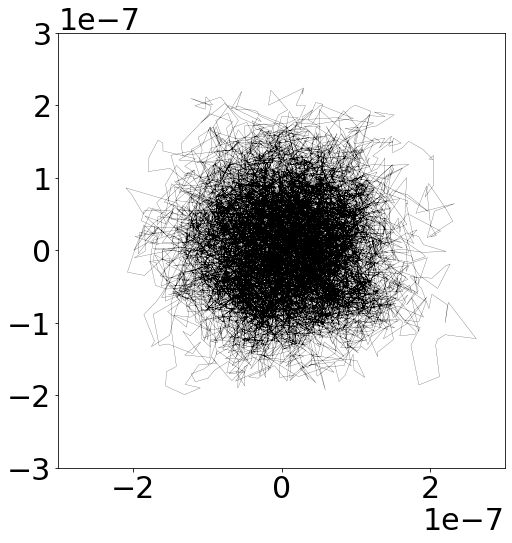

In [194]:
plt.plot(x_trapped[0,:],y_trapped[0,:], 'k',linewidth=0.2)

plt.xlim([-0.3e-6,0.3e-6])
plt.ylim([-0.3e-6,0.3e-6])

plt.gcf().set_size_inches(8, 8)


Once the trajectories have been computed, the standard analysis for optical tweezers can be applied. Even though this is something that we encourage for the interested reader, it is out of the scope of this tutorial.

### Ellipsoid: 9 degrees of freedom

Now we expand the problem up to 9 degrees of freedom. We want to have a NN that can predict the optical forces not only for spheres with different sizes, different aspect ratios, different orientations, and different refractive indices. We also want to include different NA of the objective, reaching a total number of 9DoF. If we consider also the linear dependency with the power we are up to 10DoF.

The process we need to follow is equivalent to the one we used in the previous case.

We start by loading our NN.

In [39]:
Path=os.getcwd()
Path

'C:\\Users\\Usuario\\Desktop\\Tutorial'

In [40]:
model40_ellipsoid = tf.keras.models.load_model(Path+'\\NN_1600RaysEllipsoid')

In [41]:
model40_ellipsoid.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 384)               4224      
_________________________________________________________________
dense_1 (Dense)              (None, 384)               147840    
_________________________________________________________________
dense_2 (Dense)              (None, 384)               147840    
_________________________________________________________________
dense_3 (Dense)              (None, 384)               147840    
_________________________________________________________________
dense_4 (Dense)              (None, 384)               147840    
_________________________________________________________________
dense_5 (Dense)              (None, 384)               147840    
_________________________________________________________________
dense_6 (Dense)              (None, 384)               1

We load the correction factor between the international system and the input and output of the NN

In [43]:
CorrectionFactor=np.load(Path+'\\CorrFactor.npy')
CorrFactor=CorrectionFactor

We define the parameters of our system:

In this case we want to study how the axial force ($F_z$) depends on the AR of the ellipsoid

In [57]:
ParametersInput=np.zeros([9,int(51),10])

ShortSemi=0.75*10**-6
LongSemi=np.linspace(0.75e-6,2.25e-6,9)

Theta=0.2
Phi=0.5

Z_axis=np.linspace(-4e-6,4e-6,51)

for i in range (0,9):

    p=LongSemi[i]/ShortSemi

    ParametersInput[i,:,0]=LongSemi[i] #LongSemi
    ParametersInput[i,:,1]=p #LongSemi/ShortSemi
    ParametersInput[i,:,2]=1.5 #n_r
    ParametersInput[i,:,3]=1.3 #NA

    ParametersInput[i,:,4]=0 #x
    ParametersInput[i,:,5]=0 #y
    ParametersInput[i,:,6]=Z_axis #z

    ParametersInput[i,:,7]=np.cos(Theta) #theta
    ParametersInput[i,:,8]=np.cos(Phi) #phi
    ParametersInput[i,:,9]=np.sin(Phi) #phi


We compute forces at the different points in the parameters space:

In [58]:
Store=np.zeros([9,51])

for i in range (0,9):
    ParamInputNormalized=ParametersInput[i,:,:]/CorrectionFactor[0:10]
    Predictions40_elips=model40_ellipsoid.predict(ParamInputNormalized)*CorrectionFactor[10:]
    Store[i,:]=Predictions40_elips[:,2]*1E12


We plot the calculations:

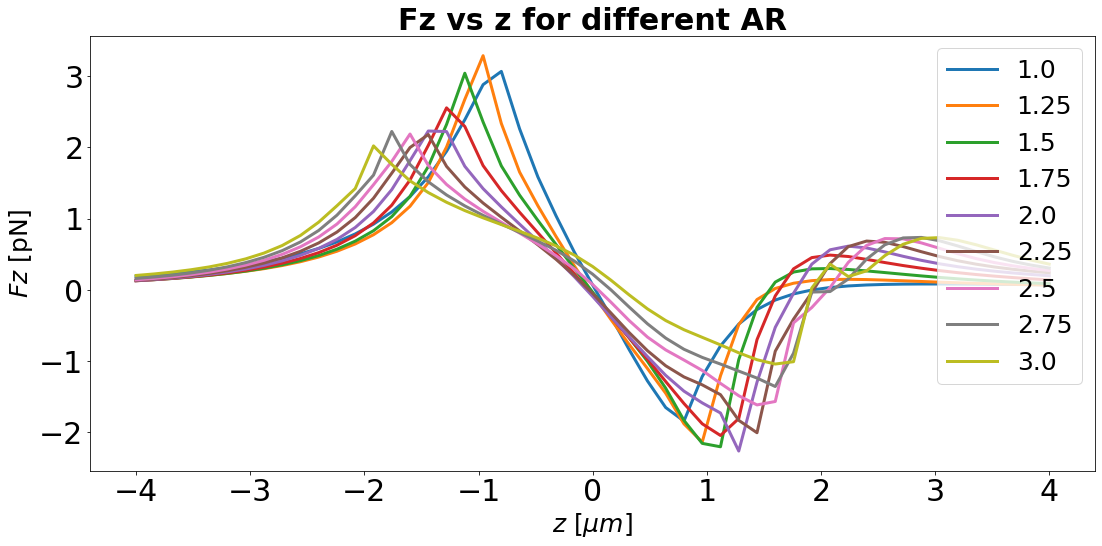

In [59]:
p=LongSemi/ShortSemi
for i in range (0,9):
    plt.plot(Z_axis*1e6,Store[i],linewidth=3)
plt.title('Fz vs z for different AR',fontweight='bold')
plt.xlabel('$z$ [$\mu m$]')
plt.ylabel('$Fz$ [pN]')
plt.legend([str(round(p[0],2)),str(p[1]),str(p[2]),str(round(p[3],2)),str(p[4]),str(p[5]),str(p[6]),str(p[7]),str(p[8])])
plt.gcf().set_size_inches(18, 8)

Lets consider now that we want to compute the force at one individual point in the space of parameters:

We define first our point

In [60]:
LongSemi=1e-6
p=1.25
n_r=1.5
NA=1.3
x=0
y=0
z=-1e-6
Theta=0.2
Phi=0.5

Point=[LongSemi,p,n_r,NA,x,y,z,np.cos(Theta),np.cos(Phi),np.sin(Phi)]

We adjust the input by applying a correction factor to match the expected input of the NN

In [61]:
PointNormalized=[list(np.divide(Point,CorrectionFactor[:10]))]

We compute the force and apply the correction factor in the output to go back to the units of the international system

In [62]:
Predictions40_elips=model40_ellipsoid.predict(PointNormalized)*CorrectionFactor[10:]


In [63]:
Predictions40_elips

array([[-2.35862794e-13, -1.05558260e-13,  3.22625134e-12,
         1.47105628e-19, -2.94187604e-19,  2.43485191e-21]])

In [64]:
Predictions40_elips[0][2]*1e12

3.2262513381805658

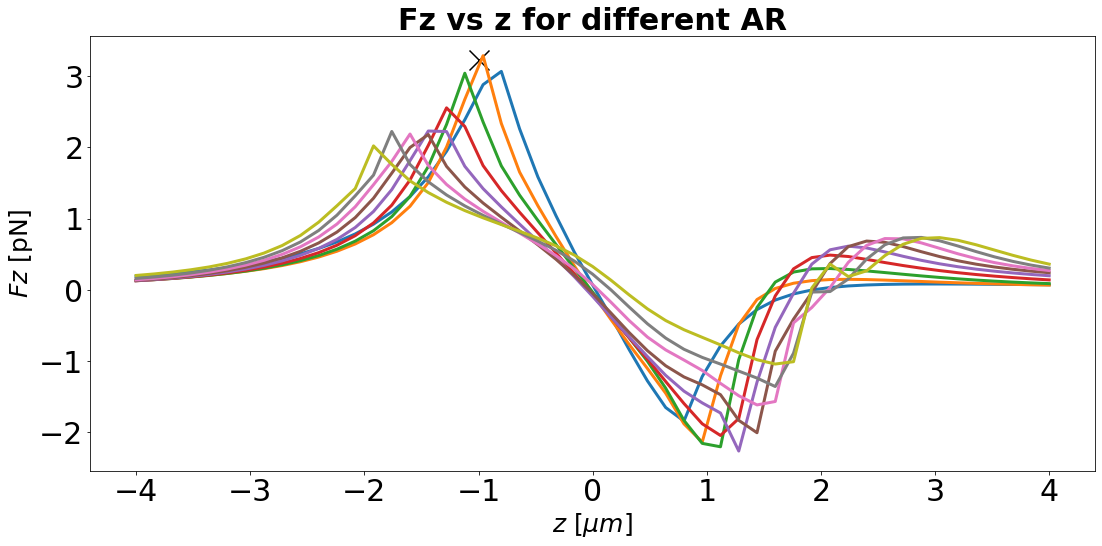

In [65]:
for i in range (0,9):
    plt.plot(Z_axis*1e6,Store[i],linewidth=3)
plt.scatter(z*1e6,Predictions40_elips[0][2]*1e12,c='k',s=400, marker='x')
plt.title('Fz vs z for different AR',fontweight='bold')
plt.xlabel('$z$ [$\mu m$]')
plt.ylabel('$Fz$ [pN]')
plt.gcf().set_size_inches(18, 8)

With this we have provided the tools to use already trained NN to compute optical forces and to use them to explore new situations or dinamically simulate systems. We encourage the interested reader to contact us for questions or assistance.

### Training a NN for 3 DoF

Here we show how we can train a basic NN for the 3DoF case.

First we define a few functions that will be useful

In [20]:
def ComputingErrorAgainstCheckingDataSet3D(PositionsChecking,ForcesChecking,NumberOfValuesToCompute,model):
    
    NN_calculations=model.predict(PositionsChecking[0:NumberOfValuesToCompute])
    T_matrix_calculations=ForcesChecking[0:NumberOfValuesToCompute]
    
    aux1=0
    for i in range (0,NumberOfValuesToCompute):
        aux2=0
        for j in range (0,3):
            aux2=aux2+(NN_calculations[i][j]-T_matrix_calculations[i][j])*(NN_calculations[i][j]-T_matrix_calculations[i][j])
        aux1=aux1+(np.sqrt(aux2))/NumberOfValuesToCompute
    return(aux1)


#We load the big file with the forces at different locations
def LoadDataFile(NameDataFile):
    
    file2 = open(NameDataFile,"r")
    aux2=file2.readlines()
    NumberOfColumns=len(aux2[0].split())
    Matrix_Data=np.zeros([len(aux2),6])
    
    for i in range (0,len(aux2)):
        for j in range (NumberOfColumns-6,NumberOfColumns):
            Matrix_Data[i,j-NumberOfColumns+6]=float((aux2[i]).split()[j])
    return(Matrix_Data)

def UnitConversion(DataArray,PositionsFactor,ForcesFactor):
    aux=len(DataArray)
    DataArrayConv=DataArray
    for i in range (0,aux):
        for j in range (0,3):
                DataArrayConv[i][j]=PositionsFactor*DataArray[i][j]
    for i in range (0,aux):
        for j in range (3,6):
                DataArrayConv[i][j]=ForcesFactor*DataArray[i][j]
    return(DataArrayConv)
            

def OrganizingDataForNN(DataArray,TrainingNumber,CheckingNumber,Desvest):
    
    np.random.shuffle(DataArray)

    Array_Positions=DataArray[0:len(DataArray),0:3]
    Array_Forces=DataArray[0:len(DataArray),3:6]

    Array_Positions_Training=Array_Positions[0:TrainingNumber,:]
    Array_Forces_Training=Array_Forces[0:TrainingNumber,:]+np.random.normal(0,Desvest)

    Array_Positions_Checking=Array_Positions[TrainingNumber:TrainingNumber+CheckingNumber,:]
    Array_Forces_Checking=Array_Forces[TrainingNumber:TrainingNumber+CheckingNumber,:]
    
    return([Array_Positions_Training,Array_Forces_Training,Array_Positions_Checking,Array_Forces_Checking])

In [21]:
Path=os.getcwd()
Path

'C:\\Users\\Usuario\\Desktop\\Tutorial'

We import the data that we will use for training (100 rays) and for checking the training and deciding when to stop (1600 rays)

In [22]:
my_fileTrain=Path+'\\Sphere 10x10 grid f=100_Ini\\force_grid_3D='
my_fileCheck=Path+'\\Sphere 40x40 grid f=100\\force_grid_3D='

In [23]:
DataArrayReadTrain=LoadDataFile(my_fileTrain+str(1)+'.txt')
for i in range (2,101):
    DataArrayReadTrain=np.append(DataArrayReadTrain,LoadDataFile(my_fileTrain+str(i)+'.txt'),axis=0)

In [24]:
DataArrayReadCheck=LoadDataFile(my_fileCheck+str(1)+'.txt')
for i in range (2,101):
    DataArrayReadCheck=np.append(DataArrayReadCheck,LoadDataFile(my_fileCheck+str(i)+'.txt'),axis=0)

We adjust the units

In [12]:
PositionsFactor=1E6
ForcesFactor=1E15

DataArrayTrain=UnitConversion(DataArrayReadTrain,PositionsFactor,ForcesFactor)
DataArrayCheck=UnitConversion(DataArrayReadCheck,PositionsFactor,ForcesFactor)

We define our NN, here you can try with other architectures.

In [13]:
model = Sequential()
model.add(Dense(16, activation='sigmoid', input_shape = (3,)))
model.add(Dense(16, activation='sigmoid'))
model.add(Dense(16, activation='sigmoid'))
model.add(Dense(16, activation='sigmoid'))
model.add(Dense(16, activation='sigmoid'))

model.add(Dense(3))

model.compile(optimizer=Adam(),loss='mse')

We define the number of data we will use for training, for checking and to compute the error.

In [25]:
TrainingNumber=950000
CheckingNumber=50000
NumberOfValuesToCompute=50000


Desvest=0

DataForNN=OrganizingDataForNN(DataArrayTrain,TrainingNumber,CheckingNumber,Desvest)

Array_Positions_Training=DataForNN[0]
Array_Forces_Training=DataForNN[1]

Array_Positions_Training_Checking=DataForNN[2]
Array_Forces_Training_Checking=DataForNN[3]

DataChecking=OrganizingDataForNN(DataArrayCheck,TrainingNumber,CheckingNumber,Desvest)

Array_Positions_Checking=DataChecking[2]
Array_Forces_Checking=DataChecking[3]

In [26]:
len(Array_Positions_Training)

950000

Here we define the batch size, the number of epochs, and how many times are we going to repeat this

In [27]:
NofLoops=10000

Epochs=10
BatchSize=1000


We make a folder to store the NNs

In [29]:
os.mkdir(Path+"\\Training")

FileExistsError: [WinError 183] No se puede crear un archivo que ya existe: 'C:\\Users\\Usuario\\Desktop\\Tutorial\\Training'

We do the training and the saving of the models

In [30]:
ErrorsTraining=np.zeros(NofLoops)
ErrorsChecking=np.zeros(NofLoops)


BestRecord=100
for i in range (0,NofLoops):
    
    hist = model.fit(Array_Positions_Training,Array_Forces_Training,validation_split=0,
    epochs= Epochs,
    batch_size=BatchSize)
    
    ErrorsTraining[i]=ComputingErrorAgainstCheckingDataSet3D(Array_Positions_Training_Checking,Array_Forces_Training_Checking,NumberOfValuesToCompute,model)
    ErrorsChecking[i]=ComputingErrorAgainstCheckingDataSet3D(Array_Positions_Checking,Array_Forces_Checking,NumberOfValuesToCompute,model)

    print(i)
    print(ErrorsTraining[i])
    print(ErrorsChecking[i])
    
    if ErrorsChecking[i]<BestRecord:    
        plt.plot(ErrorsTraining[0:i+1])
        plt.plot(ErrorsChecking[0:i+1])

        plt.savefig(Path+'\\Training\\10Rays_L5N16_124')
        model.save(Path+'\\Training\\10Rays_L5N16_124_'+str(ErrorsChecking[i]))
        BestRecord=ErrorsChecking[i]

Epoch 1/10
950/950 [==============================] - 1s 1ms/step - loss: 8431.3213
Epoch 2/10
950/950 [==============================] - 1s 1ms/step - loss: 8418.2686
Epoch 3/10
950/950 [==============================] - 1s 1ms/step - loss: 8405.6279
Epoch 4/10
950/950 [==============================] - 1s 1ms/step - loss: 8395.0859
Epoch 5/10
236/950 [======>.......................] - ETA: 0s - loss: 8663.2334

KeyboardInterrupt: 

Now you have a NN that you can use to compute optical forces!

$\textbf{Exercise:}$ In the data that we have provided to train the NN, the data points are uniformly distributed over a grid. Can you think about a way to use the same data to obtain better accuracy? Are all the regions of the grid equally relevant?

Again, do not hesitate to contact us for help, ideas, feedback, and suggestions!